# Penalized Regression Approaches for CBF Time Series Representation

Cylindir-Bell-Funnel is a synthetic dataset generated by N. Saiko. Each class has standard normal noise and its own offset term. The training set is composed of 3 different classes and 30 instances. The aim is to obtain two different adaptive piecewise approximations by using 1D fused lasso and regression tree representatives. Then, the results of two different approaches will be comparised in terms of their mean squared error.  

# Required Packages & Data Preparation

In [1]:
library(data.table)
library(ggplot2)
library(genlasso)
library(rpart)
library(rattle)
library(Metrics)

Warning message:
"package 'genlasso' was built under R version 3.6.3"Loading required package: Matrix
Loading required package: igraph
Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'rattle' was built under R version 3.6.3"Loading required package: tibble
Warning message:
"package 'tibble' was built under R version 3.6.3"
Attaching package: 'tibble'

The following object is masked from 'package:igraph':

    as_data_frame

Loading required package: bitops
Warning message:
"package 'bitops' was built under R version 3.6.3"
Attaching package: 'bitops'

The following object is masked from 'package:Matrix':

    %&%

Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll

In [2]:
train_dt <- fread("CBF_TRAIN.txt")
head(train_dt)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129
1,-0.4642765,-0.5550479,-0.84284310,-0.86589548,-0.9363963,-0.8172700,-0.2636122,-1.25804830,-1.2503934,...,-1.3310856,-1.0837000,-1.0179615,-0.9160287,-1.1342892,-0.9202237,-0.7893615,-0.6387058,-0.9636643,-1.24516910
1,-0.8969721,-0.6856855,-1.35138180,-1.45866680,-1.1653456,-1.4039293,-1.8217996,-0.83160109,-1.0163124,...,-1.0625534,-1.5686762,-1.3640403,-1.1551774,-0.9958611,-1.1637529,-0.9165233,-0.5820981,-1.2590094,-1.39252410
1,-0.4646960,-0.5677389,-0.03202276,-0.63504562,-0.6028255,-0.2668563,-0.2670613,-0.93104230,-0.4493819,...,-0.2867213,-0.6371576,-0.1552602,-0.6881293,-0.8856088,-0.7662393,-0.8653152,-0.2844857,-0.6878891,-0.88760835
3,-0.1871897,-0.6208077,-0.81566070,-0.52139796,-0.7904229,-0.9675174,-1.4870063,-0.27788714,-0.8350747,...,-0.9086154,-0.7262865,0.1837776,-0.7374441,-1.1139967,-0.3939866,-0.5878895,-0.6082319,-0.6364646,-0.34902865
2,-1.1360166,-1.3191953,-1.84462380,-0.78869178,-0.2517154,-1.4876032,-0.6687641,-0.34036037,-1.0463815,...,-1.1829110,-1.0735136,-1.6113624,-1.0643404,-0.9707364,-0.8272809,-0.9535377,-1.2701854,-1.7427579,-0.92594391
2,-0.5687087,-0.8881180,-0.04797658,-0.03803611,-0.4830683,-1.0946887,-0.9534529,-0.03000688,-0.7954546,...,-0.9907398,0.5183746,-0.2285628,-0.5652887,-0.6429980,-1.1094278,-0.1010932,-0.2339490,-0.6198269,-0.08306189


In [3]:
setnames(train_dt, "V1", "class")
train_dt <- train_dt[order(class)]
train_dt[, class:=as.character(class)]
train_dt[, id:=as.character(1:.N)]

#melting operations
train_dt_long <- melt(train_dt, id.vars=c("id", "class"))
train_dt_long[, time:=as.numeric(gsub("\\D", "", variable))-1]
train_dt_long <- train_dt_long[, list(id,class,time,value)]
train_dt_long <- train_dt_long[order(id,time)]
head(train_dt_long)

id,class,time,value
1,1,1,-0.4642765
1,1,2,-0.5550479
1,1,3,-0.8428431
1,1,4,-0.8658955
1,1,5,-0.9363963
1,1,6,-0.8172700


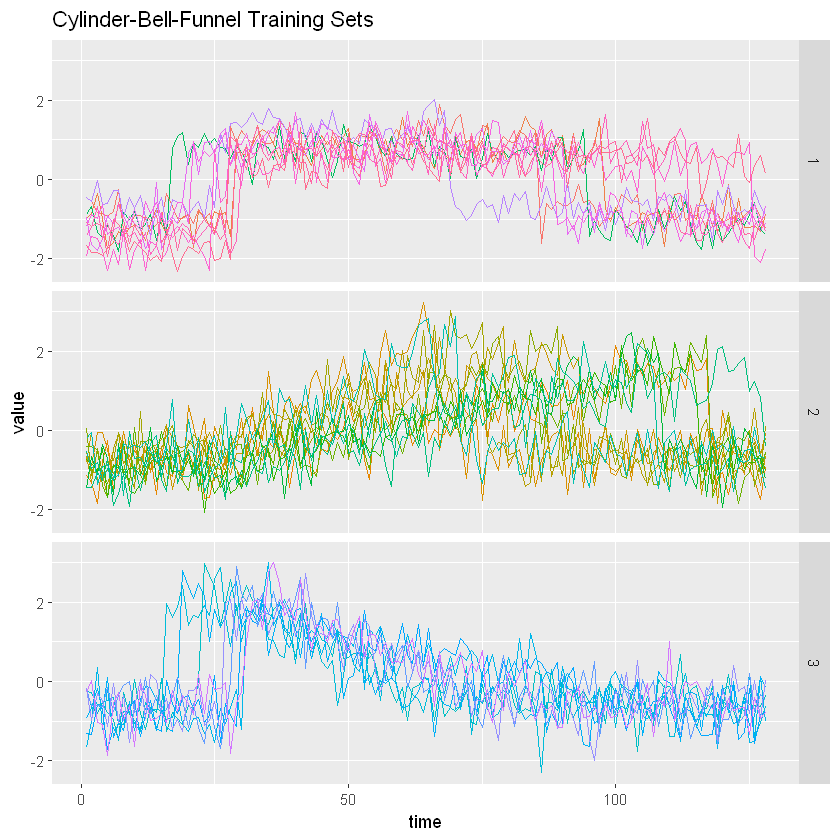

In [4]:
#visualizing time series based on class
ggplot(train_dt_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position = "none") + 
    labs(title="Cylinder-Bell-Funnel Training Sets")

Above, class 1 is cylinder, class 2 is bell, and class 3 is funnel instances. Although there are some noise in the series, the characteristic shapes of each classes can be easily seen.  

In [5]:
#for better visualization after this part
options(repr.plot.width=8, repr.plot.height=4)

# 1D Fused Lasso Representation

In this part, an appropriate representation of each instance will be obtained by 1D Fused Lasso. trendfilter() and cv.trendfilter functions of genlasso package will be used to build the models. For each instance, a λ parameter will be selected and mean squared error of the representation will be calculated. By using this functions, the folds for k-fold cross validation are chosen by placing every kth point into the same fold by default. We do not have to deal with spliting the data, the function does it for us.  

### For Class #1

In [6]:
lassoFitted <- c()
dt1_1 <- data.table(id=NA, lassoLambda=NA, lassoMSE=NA)
for (i in 1:10) {
        trainingSet <- train_dt_long[id==i]        
        out <- trendfilter(trainingSet$value, ord=0)
        cv <- cv.trendfilter(out, k=10)
        
        trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]
        tempMSE <- mse(trainingSet$value, trainingSet$lassoRep)
        tempRow <- data.table(id=i, lassoLambda=cv$lambda.min, lassoMSE=tempMSE)
        dt1_1 <- rbind(dt1_1, tempRow)
    
        lassoFitted <- c(lassoFitted, predict.genlasso(out, lambda=cv$lambda.1se)$fit)
}

dt1_1 <- dt1_1[-1]
dt1_1

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 

id,lassoLambda,lassoMSE
1,0.7435113,0.12385476
2,0.6212955,0.12151858
3,0.6623808,0.09309762
4,1.4181884,0.11448341
5,0.1519257,0.12286685
6,0.8693928,0.16815165
7,0.9706832,0.08832202
8,0.7744089,0.12431816
9,1.2008345,0.13779886
10,0.5448199,0.11095925


Each instance's appropriate lambda value and their MSE values are kept in a data table.  

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


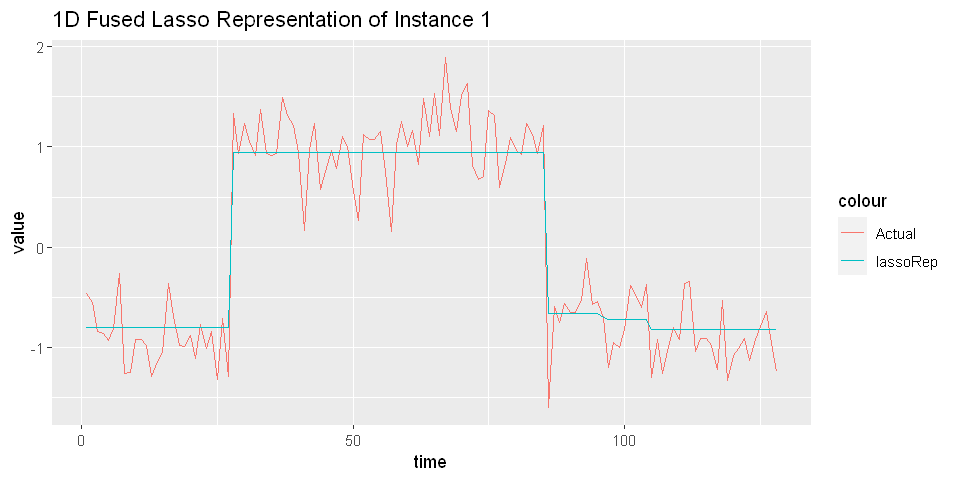

In [7]:
selected_series_id <- 1
selectedSeries <- train_dt_long[id==selected_series_id]

out <- fusedlasso1d(selectedSeries$value)
cv <- cv.trendfilter(out)
selectedSeries[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

ggplot(selectedSeries, aes(x=time)) + geom_line(aes(y=value, color="Actual")) +
    geom_line(aes(y=lassoRep, color="lassoRep")) + labs(title="1D Fused Lasso Representation of Instance 1")

Above, instance of id=1 is selected and the visualizaton on representing the series is made. It captured the mean change but still the representation is weak.  

Now, the representation that has the minimum MSE value will be selected and its graph will be drawed over all instances in class 1 just for getting a good visualization.  

In [8]:
dt1_1[which.min(dt1_1$lassoMSE)]

id,lassoLambda,lassoMSE
7,0.9706832,0.08832202


The model made on instance 7 is selected because it has the minimum MSE value.  

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


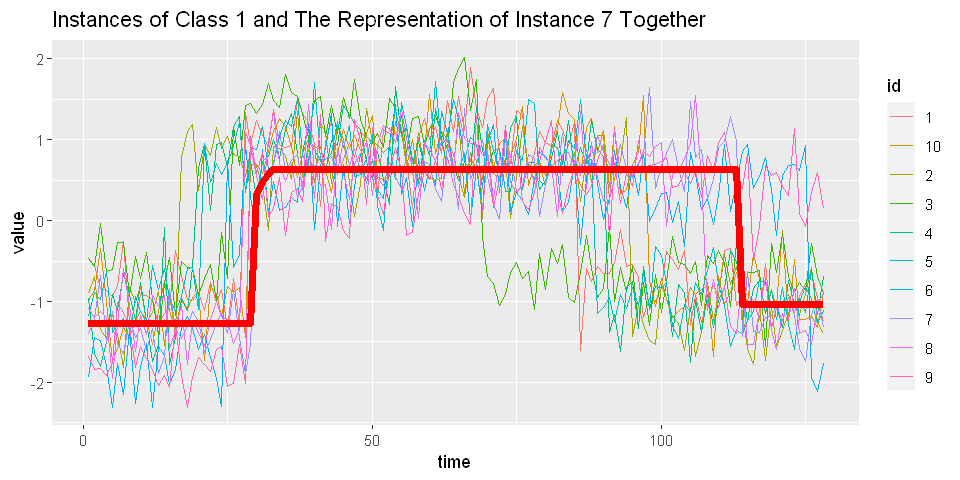

In [9]:
trainingSet <- train_dt_long[id==7]        

out <- trendfilter(trainingSet$value, ord=0)
cv <- cv.trendfilter(out)     
trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

tempSet <- train_dt_long[class==1]
tempSet <- tempSet[, lassoRep:=rep(predict.genlasso(out, lambda=cv$lambda.1se)$fit, 10)]

ggplot(tempSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=lassoRep), size=2, color="red") + 
    labs(title="Instances of Class 1 and The Representation of Instance 7 Together")

### For Class #2

In [10]:
dt1_2 <- data.table(id=NA, lassoLambda=NA, lassoMSE=NA)
for (i in 11:22) {
        trainingSet <- train_dt_long[id==i]        
        out <- trendfilter(trainingSet$value, ord=0)
        cv <- cv.trendfilter(out)
        
        trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]
        tempMSE <- mse(trainingSet$value, trainingSet$lassoRep)
        tempRow <- data.table(id=i, lassoLambda=cv$lambda.min, lassoMSE=tempMSE)
        dt1_2 <- rbind(dt1_2, tempRow)
    
        lassoFitted <- c(lassoFitted, predict.genlasso(out, lambda=cv$lambda.1se)$fit)

}

dt1_2 <- dt1_2[-1]
dt1_2

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


id,lassoLambda,lassoMSE
11,1.0216196,0.1830902
12,1.3541788,0.2298816
13,1.0120080,0.1524987
14,0.9873853,0.2178883
15,0.8361207,0.2483714
16,0.9473808,0.1926714
17,1.0462665,0.2220502
18,0.5990575,0.1145535
19,1.0190469,0.2271525
20,0.9586536,0.1666685


Again, each instance's appropriate lambda value and their MSE values are kept in a data table.

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


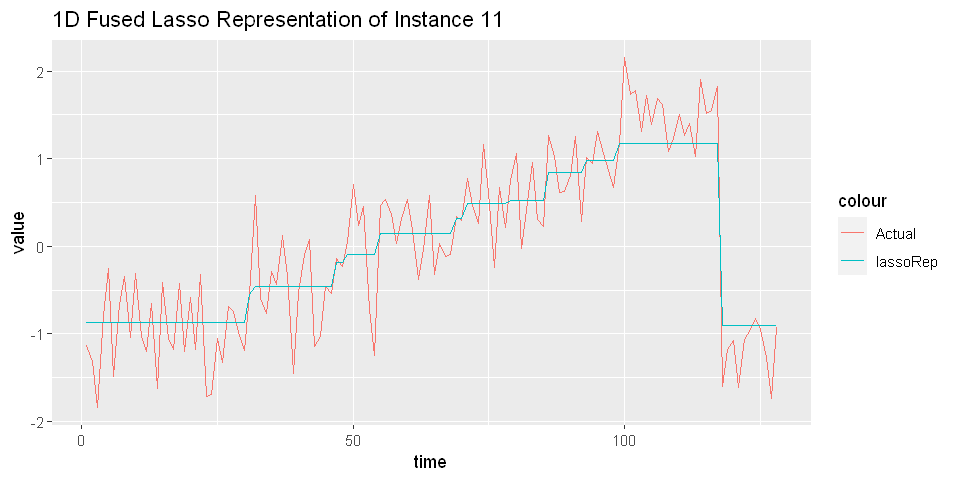

In [11]:
selected_series_id <- 11
selectedSeries <- train_dt_long[id==selected_series_id]

out <- fusedlasso1d(selectedSeries$value)
cv <- cv.trendfilter(out)
selectedSeries[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

ggplot(selectedSeries, aes(x=time)) + geom_line(aes(y=value, color="Actual")) +
    geom_line(aes(y=lassoRep, color="lassoRep")) + labs(title="1D Fused Lasso Representation of Instance 11")

Above, instance of id=11 is selected and the visualizaton on representing the series is made. It captured the mean changes and also the shape.  

Now, the representation that has the minimum MSE value will be selected and its graph will be drawed over all instances in class 2 just for getting a good visualization.

In [12]:
dt1_2[which.min(dt1_2$lassoMSE)]

id,lassoLambda,lassoMSE
18,0.5990575,0.1145535


The model made on instance 18 is selected because it has the minimum MSE value.  

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


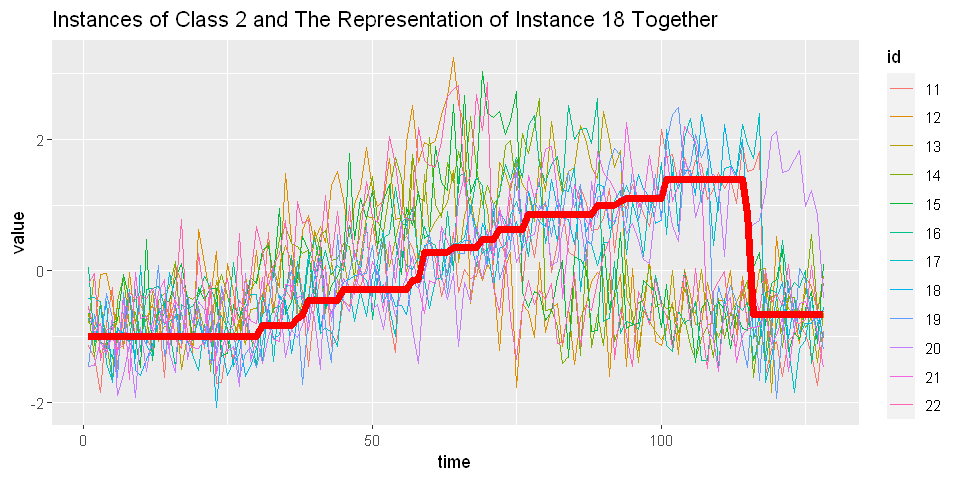

In [13]:
trainingSet <- train_dt_long[id==18]        

out <- trendfilter(trainingSet$value, ord=0)
cv <- cv.trendfilter(out)     
trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

tempSet <- train_dt_long[class==2]
tempSet <- tempSet[, lassoRep:=rep(predict.genlasso(out, lambda=cv$lambda.1se)$fit, 12)]

ggplot(tempSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=lassoRep), size=2, color="red") + 
    labs(title="Instances of Class 2 and The Representation of Instance 18 Together")

### For Class #3

In [14]:
dt1_3 <- data.table(id=NA, lassoLambda=NA, lassoMSE=NA)
for (i in 23:30) {
        trainingSet <- train_dt_long[id==i]        
        out <- trendfilter(trainingSet$value, ord=0)
        cv <- cv.trendfilter(out)
        
        trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]
        tempMSE <- mse(trainingSet$value, trainingSet$lassoRep)
        tempRow <- data.table(id=i, lassoLambda=cv$lambda.min, lassoMSE=tempMSE)
        dt1_3 <- rbind(dt1_3, tempRow)
    
        lassoFitted <- c(lassoFitted, predict.genlasso(out, lambda=cv$lambda.1se)$fit)
}

dt1_3 <- dt1_3[-1]
dt1_3

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


id,lassoLambda,lassoMSE
23,1.2146587,0.1787097
24,1.1242629,0.2042644
25,0.9764708,0.2030403
26,0.3821081,0.1974043
27,0.9932129,0.1699462
28,0.7085788,0.1961253
29,1.3717851,0.2176085
30,0.5490182,0.2113220


The same table for class 3 is obtained above. Next, instance 23 will be drawn.  

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


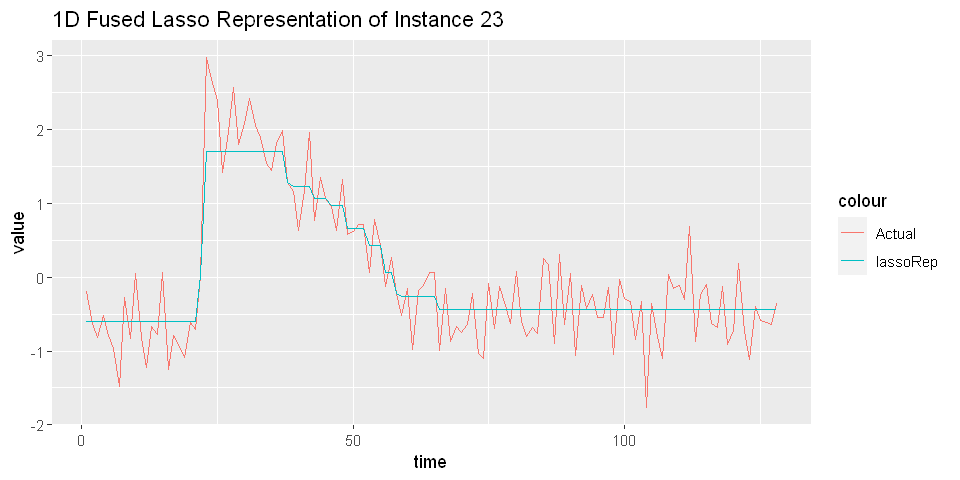

In [15]:
selected_series_id <- 23
selectedSeries <- train_dt_long[id==selected_series_id]

out <- fusedlasso1d(selectedSeries$value)
cv <- cv.trendfilter(out)
selectedSeries[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

ggplot(selectedSeries, aes(x=time)) + geom_line(aes(y=value, color="Actual")) +
    geom_line(aes(y=lassoRep, color="lassoRep")) + labs(title="1D Fused Lasso Representation of Instance 23")

The representation seems to good actually. Below, the model with the minimum MSE value will be drawn again.  

In [16]:
dt1_3[which.min(dt1_3$lassoMSE)]

id,lassoLambda,lassoMSE
27,0.9932129,0.1699462


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 


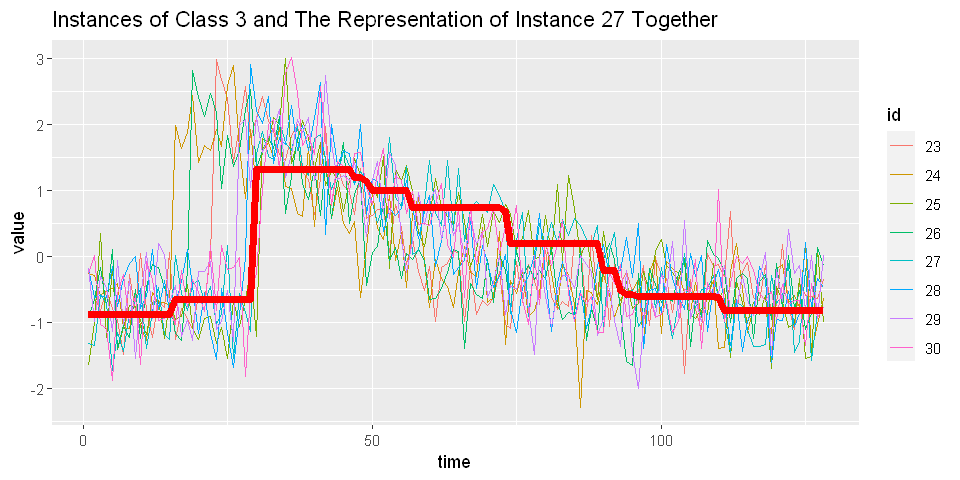

In [17]:
trainingSet <- train_dt_long[id==27]        

out <- trendfilter(trainingSet$value, ord=0)
cv <- cv.trendfilter(out)
trainingSet[, lassoRep:=predict.genlasso(out, lambda=cv$lambda.1se)$fit]

tempSet <- train_dt_long[class==3]
tempSet <- tempSet[, lassoRep:=rep(predict.genlasso(out, lambda=cv$lambda.1se)$fit, 8)]

ggplot(tempSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=lassoRep), size=2, color="red") + 
    labs(title="Instances of Class 3 and The Representation of Instance 27 Together")

In [18]:
lassoTable <- rbind(dt1_1[, class:=1], dt1_2[, class:=2], dt1_3[, class:=3])
setcolorder(lassoTable, c("id", "class", "lassoLambda", "lassoMSE"))
lassoTable

id,class,lassoLambda,lassoMSE
1,1,0.7435113,0.12385476
2,1,0.6212955,0.12151858
3,1,0.6623808,0.09309762
4,1,1.4181884,0.11448341
5,1,0.1519257,0.12286685
6,1,0.8693928,0.16815165
7,1,0.9706832,0.08832202
8,1,0.7744089,0.12431816
9,1,1.2008345,0.13779886
10,1,0.5448199,0.11095925


The tables for each class is merged. It will be used in the conclusion part.  

# Regression Tree Representation

In this part, regression trees will be used to get an appropriate representation of each instance. rpart package will be used to build the trees. maxdepth parameter of the rpart function will be tuned between 3 and 8. Again, the appropriate maxdepth parameter and the MSE value of each representation will be kept in a data table.  

The subsampling will be made by manually. Every tree of an instance will be build on 10 different training sets. 

### For Class #1

In [19]:
treeFitted <- c()
dt2_1 <- data.table(id=NA, treeMaxDepth=NA, treeMSE=NA)
for (i in 1:10) {
    minMSE <- 999
    maxDepth <- 0
    
    for (j in 0:9) {
        trainingSet <- train_dt_long[time%%10!=j & id==i]
        testSet <- train_dt_long[time%%10!=j & id==i] 
        
        for (k in 3:8) {
            treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=k, cp=0, minsplit=20, minbucket=10))
            testSet <- testSet[, treeRep:=predict(treeFit, testSet)]
            tempMSE <- mse(testSet$value, testSet$treeRep)
            if (tempMSE <  minMSE) {
                minMSE <- tempMSE
                maxDepth <- k
            }
        }
    }
    
    tempRow <- data.table(id=i, treeMaxDepth=maxDepth, treeMSE=minMSE)
    dt2_1 <- rbind(dt2_1, tempRow)
    
    tempTree <- rpart(value~time, train_dt_long[id==i], control=rpart.control(maxdepth=maxDepth, cp=0, minsplit=20, minbucket=10))
    treeFitted <- c(treeFitted, predict(tempTree, train_dt_long[id==i]))
}

dt2_1 <- dt2_1[-1]
dt2_1

id,treeMaxDepth,treeMSE
1,4,0.06616085
2,5,0.09128709
3,4,0.08092611
4,6,0.09286413
5,6,0.08692029
6,5,0.20297957
7,6,0.06201782
8,5,0.08483671
9,6,0.10776257
10,5,0.07879550


The parameters of the model that has the minimum MSE value will be used to build a tree on class 1 training set in order to get a good visualization.  

In [20]:
dt2_1[which.min(dt2_1$treeMSE)]

id,treeMaxDepth,treeMSE
7,6,0.06201782


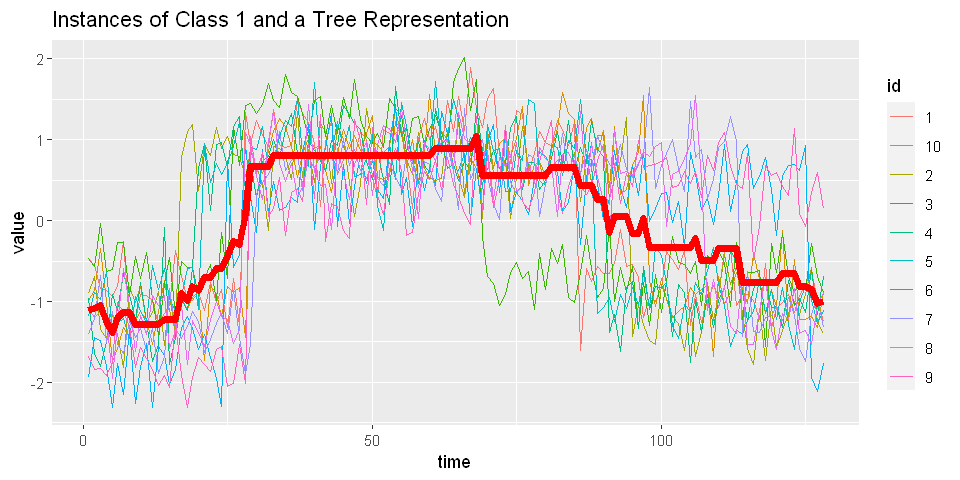

In [21]:
trainingSet <- train_dt_long[class==1]        

treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=6, cp=0, minsplit=20, minbucket=10))
trainingSet[, treeRep:=predict(treeFit, trainingSet)]

ggplot(trainingSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=treeRep), size=2, color="red") + 
    labs(title="Instances of Class 1 and a Tree Representation")

### For Class #2

In [22]:
dt2_2 <- data.table(id=NA, treeMaxDepth=NA, treeMSE=NA)
for (i in 11:22) {
    minMSE <- 999
    maxDepth <- 0
    
    for (j in 0:9) {
        trainingSet <- train_dt_long[time%%10!=j & id==i]
        testSet <- train_dt_long[time%%10!=j & id==i] 
        
        for (k in 3:8) {
            treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=k, cp=0, minsplit=20, minbucket=10))
            testSet <- testSet[, treeRep:=predict(treeFit, testSet)]
            tempMSE <- mse(testSet$value, testSet$treeRep)
            if (tempMSE <  minMSE) {
                minMSE <- tempMSE
                maxDepth <- k
            }
        }
    }
    
    tempRow <- data.table(id=i, treeMaxDepth=maxDepth, treeMSE=minMSE)
    dt2_2 <- rbind(dt2_2, tempRow)
    
    tempTree <- rpart(value~time, train_dt_long[id==i], control=rpart.control(maxdepth=maxDepth, cp=0, minsplit=20, minbucket=10))
    treeFitted <- c(treeFitted, predict(tempTree, train_dt_long[id==i]))
}

dt2_2 <- dt2_2[-1]
dt2_2

id,treeMaxDepth,treeMSE
11,4,0.1364510
12,4,0.1859972
13,5,0.1352015
14,4,0.1499565
15,4,0.2033407
16,5,0.1350086
17,6,0.1752684
18,5,0.1016579
19,5,0.1857698
20,4,0.1476387


Again, the parameters of the model that has the minimum MSE value will be used to build a tree on class 2 training set in order to get a good visualization.  

In [23]:
dt2_2[which.min(dt2_2$treeMSE)]

id,treeMaxDepth,treeMSE
18,5,0.1016579


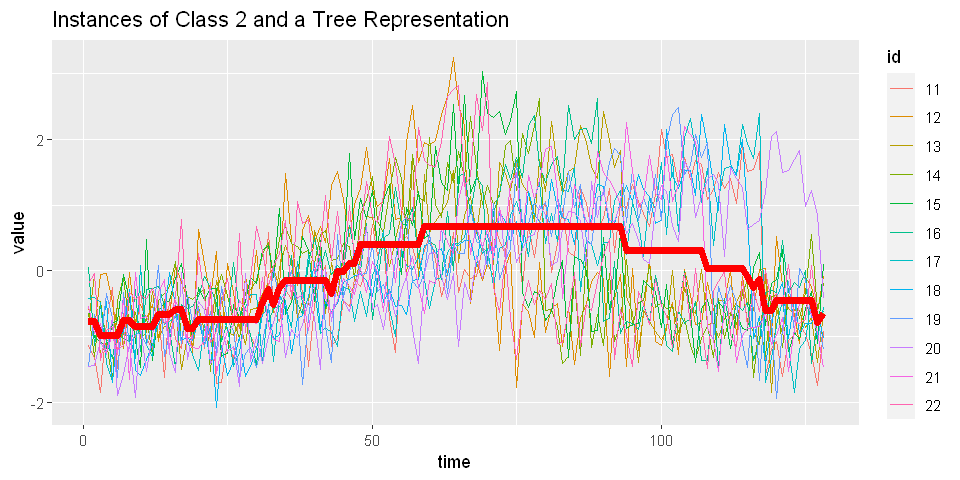

In [24]:
trainingSet <- train_dt_long[class==2]        

treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=5, cp=0, minsplit=20, minbucket=10))
trainingSet[, treeRep:=predict(treeFit, trainingSet)]

ggplot(trainingSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=treeRep), size=2, color="red") + 
    labs(title="Instances of Class 2 and a Tree Representation")

### For Class #3

In [25]:
dt2_3 <- data.table(id=NA, treeMaxDepth=NA, treeMSE=NA)
for (i in 23:30) {
    minMSE <- 999
    maxDepth <- 0
    
    for (j in 0:9) {
        trainingSet <- train_dt_long[time%%10!=j & id==i]
        testSet <- train_dt_long[time%%10!=j & id==i] 
        
        for (k in 3:8) {
            treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=k, cp=0, minsplit=20, minbucket=10))
            testSet <- testSet[, treeRep:=predict(treeFit, testSet)]
            tempMSE <- mse(testSet$value, testSet$treeRep)
            if (tempMSE <  minMSE) {
                minMSE <- tempMSE
                maxDepth <- k
            }
        }
    }
    
    tempRow <- data.table(id=i, treeMaxDepth=maxDepth, treeMSE=minMSE)
    dt2_3 <- rbind(dt2_3, tempRow)
    
    tempTree <- rpart(value~time, train_dt_long[id==i], control=rpart.control(maxdepth=maxDepth, cp=0, minsplit=20, minbucket=10))
    treeFitted <- c(treeFitted, predict(tempTree, train_dt_long[id==i]))
}

dt2_3 <- dt2_3[-1]
dt2_3

id,treeMaxDepth,treeMSE
23,5,0.1680902
24,4,0.1591169
25,4,0.1363342
26,4,0.1664148
27,4,0.1496918
28,4,0.1831297
29,4,0.1645035
30,4,0.1836665


Lastly, the parameters of the model that has the minimum MSE value will be used to build a tree on class 3 training set in order to get a good visualization.  

In [26]:
dt2_3[which.min(dt2_3$treeMSE)]

id,treeMaxDepth,treeMSE
25,4,0.1363342


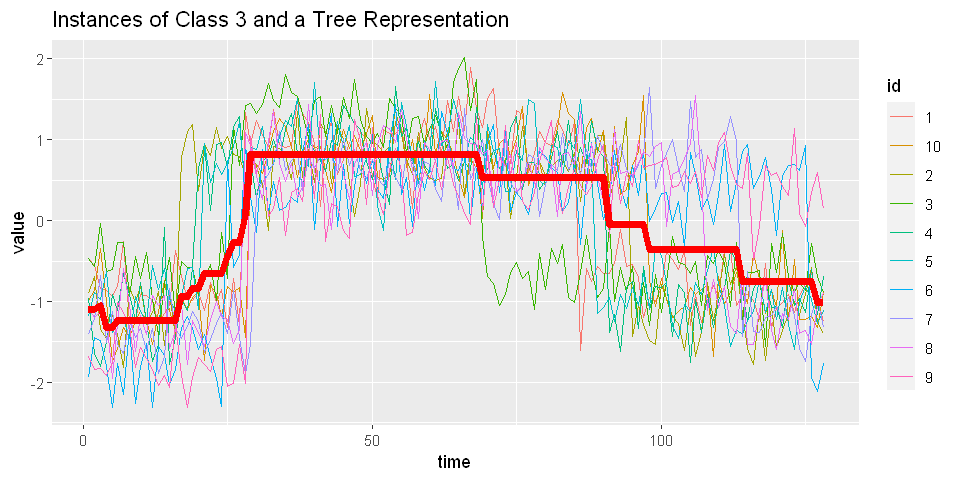

In [27]:
trainingSet <- train_dt_long[class==1]        

treeFit <- rpart(value~time, trainingSet, control=rpart.control(maxdepth=4, cp=0, minsplit=20, minbucket=10))
trainingSet[, treeRep:=predict(treeFit, trainingSet)]

ggplot(trainingSet, aes(x=time)) + geom_line(aes(y=value, color=id)) + geom_line(aes(y=treeRep), size=2, color="red") + 
    labs(title="Instances of Class 3 and a Tree Representation")

In [28]:
treeTable <- rbind(dt2_1, dt2_2, dt2_3)
treeTable

id,treeMaxDepth,treeMSE
1,4,0.06616085
2,5,0.09128709
3,4,0.08092611
4,6,0.09286413
5,6,0.08692029
6,5,0.20297957
7,6,0.06201782
8,5,0.08483671
9,6,0.10776257
10,5,0.07879550


The tables for each class is merged. It will be used in the conclusion part.  

# MSE Comparison of Two Representations

Below, the results of two different representation approaches can be seen with their parameters for each instance. To draw box plot, melting operations will be used.  

In [29]:
finalTable <- cbind(lassoTable, treeTable[,2:3])
finalTable

id,class,lassoLambda,lassoMSE,treeMaxDepth,treeMSE
1,1,0.7435113,0.12385476,4,0.06616085
2,1,0.6212955,0.12151858,5,0.09128709
3,1,0.6623808,0.09309762,4,0.08092611
4,1,1.4181884,0.11448341,6,0.09286413
5,1,0.1519257,0.12286685,6,0.08692029
6,1,0.8693928,0.16815165,5,0.20297957
7,1,0.9706832,0.08832202,6,0.06201782
8,1,0.7744089,0.12431816,5,0.08483671
9,1,1.2008345,0.13779886,6,0.10776257
10,1,0.5448199,0.11095925,5,0.07879550


In [30]:
#melting operations
finalTable_melt <- melt(finalTable[,-c(3,5)], id.vars=c("id", "class"))
colnames(finalTable_melt) <- c("id", "class", "model", "MSE")

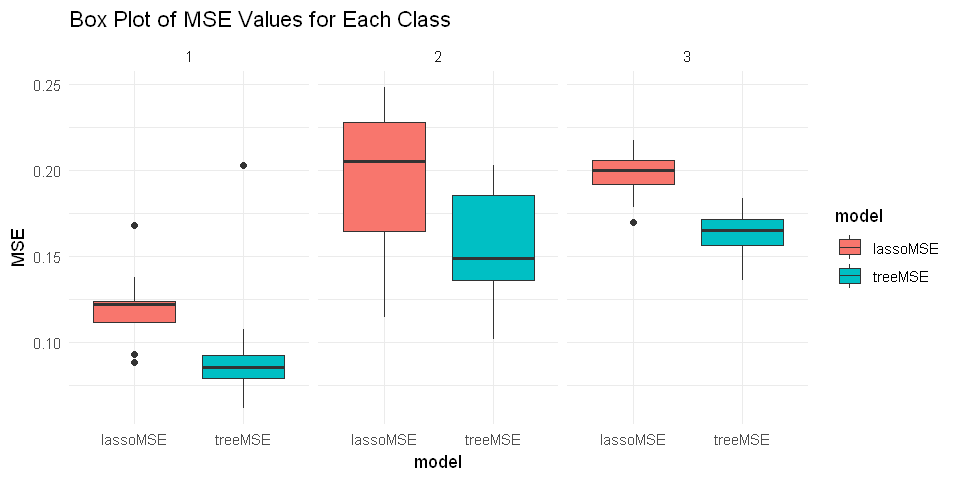

In [31]:
ggplot(finalTable_melt, aes(x=model, y=MSE, fill=model)) + 
    geom_boxplot() + 
    theme_minimal() + facet_wrap(~class) +
    labs(title="Box Plot of MSE Values for Each Class")

For each class, tree representations are better in the sense that it has less MSE values in general. Therefore, regression tree approach is selected while representing the CBF dataset.  

# Accuracy Calculations on the Training Set

### 1-NN Approach

In [32]:
train_dt_matrix <- as.matrix(train_dt)
train_class <- train_dt_matrix[,1]
train_dt_matrix <- train_dt_matrix[, 2:ncol(train_dt_matrix)]

KNN_euc_dist <- as.matrix(dist(train_dt_matrix))
diag(KNN_euc_dist) <- 9999

KNN_neighborhood <- apply(KNN_euc_dist, 1, order)
KNN_pred <- train_class[KNN_neighborhood[1,]]

table(train_class, KNN_pred)

KNN_acc <- sum(train_class==KNN_pred)/length(KNN_pred)
print(KNN_acc)

           KNN_pred
train_class  1  2  3
          1 10  0  0
          2  0 11  1
          3  0  0  8

[1] 0.9666667


### 1D Fused Lasso Approach

In [33]:
lasso_matrix <- matrix(lassoFitted, nrow =30, ncol=128)

lasso_euc_dist <- as.matrix(dist(lasso_matrix))
diag(lasso_euc_dist) <- 9999

lasso_neighborhood <- apply(lasso_euc_dist, 1, order)
lasso_pred <- train_class[lasso_neighborhood[1,]]

table(train_class, lasso_pred)

lasso_acc <- sum(train_class==lasso_pred)/length(lasso_pred)
print(lasso_acc)

           lasso_pred
train_class  1  2  3
          1 10  0  0
          2  0 12  0
          3  0  1  7

[1] 0.9666667


### Regression Tree Approach

In [34]:
tree_matrix <- matrix(treeFitted, nrow =30, ncol=128)

tree_euc_dist <- as.matrix(dist(tree_matrix))
diag(tree_euc_dist) <- 9999

tree_neighborhood <- apply(tree_euc_dist, 1, order)
tree_pred <- train_class[tree_neighborhood[1,]]

table(train_class, tree_pred)

tree_acc <- sum(train_class==tree_pred)/length(tree_pred)
print(tree_acc)

           tree_pred
train_class  1  2  3
          1 10  0  0
          2  0 12  0
          3  0  0  8

[1] 1


Above, it is clear that regression tree approach has the best accuracy level. It is also better than 1D fused lasso approach in the sense that it has less MSE values in general as discussed on the previous part.  
Although 1-NN and 1D fused lasso approaches has the same accuracy level, they made a mistake on different classes.   

# Conclusion

In this assignment, 30 instances of CBF data was given as splitted into 3 classes. Each time serie had 128 observations. The aim was obtaining two different adaptive piecewise approximations by using 1D fused lasso and regression tree representatives. After the data manipulations and visualizations parts, lasso and tree models were built on each instance and their parameters and errors were kept in a table. Then, these two approach were compared by using MSE values. Lastly, accuracy calculations were made. In this step, 1-NN approach was also considered.  
  
When we look at the graphs and numerical results, it can be seen that regression trees worked better for CBF dataset. This method made its predictions with 100% accuracy. Therefore, this approach is chosen for representation purposes. 